In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [4]:
# colours is a vector of BGR values which are used to identify individuals in the video
# t_id is termite id and is also used for individual identification
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in t_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 5
t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 51
offset = 25

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = 50
max_area = 1000

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = True

# name of source video and paths
video = 'zebrafish_video'
input_vidpath = '/Users/vivekhsridhar/Documents/Code/Python/OpenCV/tracktor/videos/' + video + '.mp4'
output_vidpath = '/Users/vivekhsridhar/Documents/Code/Python/OpenCV/tracktor/output/' + video + '_tracked.mp4'
output_filepath = '/Users/vivekhsridhar/Documents/Code/Python/OpenCV/tracktor/output/' + video + '_tracked.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

The cell below runs the tracking code

In [6]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

df = []
last = 0

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    this = cap.get(1)
    if ret == True:
        # Preprocess the image for background subtraction
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        if len(meas_now) != n_inds:
            contours, meas_now = tr.apply_k_means(contours, n_inds, meas_now)
        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last >= this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [5]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,783.514170,62.967611,A
1,1,3.0,174.192848,60.541507,B
2,2,3.0,303.360000,119.509630,C
3,3,3.0,193.814035,293.143860,D
4,4,3.0,226.002179,333.840959,E


In [6]:
for num,val in enumerate(np.unique(df['id'])):
    df.loc[df['id'] == val, 'id'] = num

df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,783.514170,62.967611,0
1,1,3.0,174.192848,60.541507,1
2,2,3.0,303.360000,119.509630,2
3,3,3.0,193.814035,293.143860,3
4,4,3.0,226.002179,333.840959,4


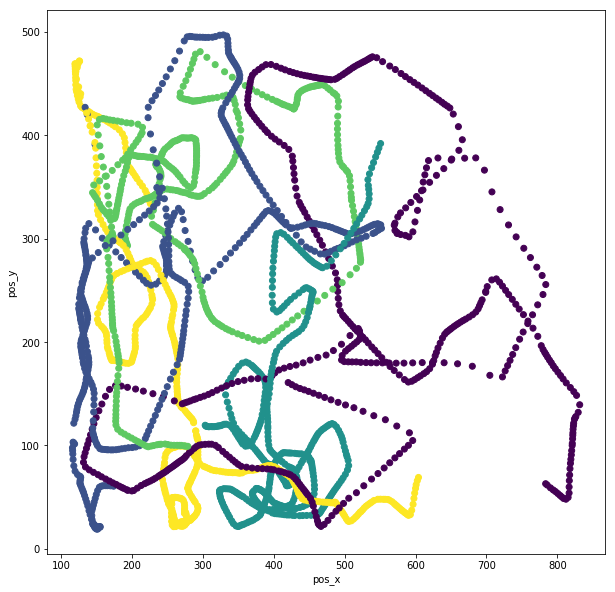

In [10]:
import matplotlib.pyplot as plt

tmp = df[df['frame'] < 500]
plt.figure(figsize=(10,10))
plt.scatter(tmp['pos_x'], tmp['pos_y'], c=tmp['id'])
plt.xlabel('pos_x')
plt.ylabel('pos_y')
plt.show()